In [2]:
import numpy as np                  # for working with tensors outside the network
import pandas as pd                 # for data reading and writing
import matplotlib.pyplot as plt     # for data inspection
import os
from skimage.io import imread
from skimage.transform import resize

In [3]:
from keras.layers import Input, Conv2D, Activation, BatchNormalization, GlobalAveragePooling2D, Dense, Dropout
from keras.layers import add
from tensorflow.keras.layers import concatenate
from keras.activations import relu, softmax
from keras.models import Model
from keras import regularizers
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler, ModelCheckpoint



In [4]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

In [10]:
def block(n_output, upscale=False):
    # n_output: number of feature maps in the block
    # upscale: should we use the 1x1 conv2d mapping for shortcut or not
    
    # keras functional api: return the function of type
    # Tensor -> Tensor
    def f(x):
        
        # H_l(x):
        # first pre-activation
        h = BatchNormalization()(x)
        h = Activation(relu)(h)
        
        # first convolution
        h = Conv2D(kernel_size=3, filters=n_output, strides=1, padding='same', kernel_regularizer=regularizers.l2(0.01))(h)
        
        # second pre-activation
        h = BatchNormalization()(x)
        h = Activation(relu)(h)
        # second convolution
        h = Conv2D(kernel_size=3, filters=n_output, strides=1, padding='same', kernel_regularizer=regularizers.l2(0.01))(h)
        
        # f(x):
        if upscale:
            # 1x1 conv2d
            f = Conv2D(kernel_size=1, filters=n_output, strides=1, padding='same')(x)
        else:
            # identity
            f = x
        
        # F_l(x) = f(x) + H_l(x):
        return add([f, h])
    
    return f

In [112]:
# input tensor is the 128x128 grayscale image of X-ray
def ResNet():
    input_tensor = Input((128, 128, 1))

    # first conv2d with post-activation to transform the input data to some reasonable form
    x = Conv2D(kernel_size=3, filters=16, strides=1, padding='same', kernel_regularizer=regularizers.l2(0.01))(input_tensor)
    x = BatchNormalization()(x)
    x = Activation(relu)(x)

    # F_1
    x = block(16)(x)
    # F_2
    x = block(16)(x)

    # F_3
    # H_3 is the function from the tensor of size 28x28x16 to the the tensor of size 28x28x32
    # and we can't add together tensors of inconsistent sizes, so we use upscale=True
    # x = block(32, upscale=True)(x)       # !!! <------- Uncomment for local evaluation
    # F_4
    # x = block(32)(x)                     # !!! <------- Uncomment for local evaluation
    # F_5
    # x = block(32)(x)                     # !!! <------- Uncomment for local evaluation

    # F_6
    # x = block(48, upscale=True)(x)       # !!! <------- Uncomment for local evaluation
    # F_7
    # x = block(48)(x)                     # !!! <------- Uncomment for local evaluation

    # last activation of the entire network's output
    x = BatchNormalization()(x)
    x = Activation(relu)(x)

    # average pooling across the channels
    # 28x28x48 -> 1x48
    x = GlobalAveragePooling2D()(x)

    # dropout for more robust learning
    x = Dropout(0.2)(x)

    # last softmax layer
    x = Dense(units=9, kernel_regularizer=regularizers.l2(0.01))(x)
    x = Activation(softmax)(x)

    model = Model(inputs=input_tensor, outputs=x)
    return model

model = ResNet()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [133]:
# Data and model parameters
img_ch, img_width, img_height = 1, 128, 128
n_epochs = 80
Batch_Size = 32
Base = 8
LR = 0.00001

TRAIN_DIR = '/DL_course_data/Lab1/X_ray/train/'
VAL_DIR = '/DL_course_data/Lab1/X_ray/test/'

In [122]:
from random import shuffle

def gen_labels(im_name, pat1, pat2, pat3, pat4, pat5, pat6, pat7, pat8, pat9):
    '''
    Parameters
    ----------
    im_name : Str
        The image file name.
    pat1 : Str
        A string pattern in the filename for 1st class, e.g "Mel"
    pat2 : Str
        A string pattern in the filename 2nd class, e.g, "Nev"
    Returns
    -------
    Label : Numpy array
        Class label of the filename name based on its pattern.
    '''
    if pat1 in im_name:
        label = np.array([0])
    elif pat2 in im_name:
        label = np.array([1])
    elif pat3 in im_name:
        label = np.array([2])
    elif pat4 in im_name:
        label = np.array([3])
    elif pat5 in im_name:
        label = np.array([4])
    elif pat6 in im_name:
        label = np.array([5])
    elif pat7 in im_name:
        label = np.array([6])
    elif pat8 in im_name:
        label = np.array([7])
    elif pat9 in im_name:
        label = np.array([8])
    return label

def get_data(data_path, data_list, img_h, img_w):
    """
    Parameters
    ----------
    train_data_path : Str
        Path to the data directory
    train_list : List
        A list containing the name of the images.
    img_h : Int
        image height to be resized to.
    img_w : Int
        image width to be resized to.
    Returns
    -------
    img_labels : Nested List
        A nested list containing the loaded images along with their
        correcponding labels.
    """
    img_labels = []
    for item in enumerate(data_list):
        img = imread(os.path.join(data_path, item[1]), as_gray = True) # "as_grey"
        img = resize(img, (img_h, img_w), anti_aliasing = True).astype('float32')
        img_labels.append([np.array(img), gen_labels(item[1], 'C1', 'C2','C3','C4','C5','C6','C7','C8','C9')])
        if item[0] % 100 == 0:
             print('Reading: {0}/{1}  of train images'.format(item[0], len(data_list)))
    shuffle(img_labels)
    return img_labels

def get_data_arrays(nested_list, img_h, img_w):
    """
    Parameters
    ----------
    nested_list : nested list
        nested list of image arrays with corresponding class labels.
    img_h : Int
        Image height.
    img_w : Int
    Image width.
    Returns
    -------
    img_arrays : Numpy array
        4D Array with the size of (n_data,img_h,img_w, 1)
    label_arrays : Numpy array
        1D array with the size (n_data).
    """
    img_arrays = np.zeros((len(nested_list), img_h, img_w), dtype = np.float32)
    label_arrays = np.zeros((len(nested_list)), dtype = np.int32)
    for ind in range(len(nested_list)):
        img_arrays[ind] = nested_list[ind][0]
        label_arrays[ind] = nested_list[ind][1]
    img_arrays = np.expand_dims(img_arrays, axis =3)
    return img_arrays, label_arrays

def get_train_test_arrays(train_data_path, test_data_path, train_list,
                          test_list, img_h, img_w):
    """
    Get the directory to the train and test sets, the files names and
    the size of the image and return the image and label arrays for
    train and test sets.
    """
    train_data = get_data(train_data_path, train_list, img_h, img_w)
    test_data = get_data(test_data_path, test_list, img_h, img_w)
    train_img, train_label =  get_data_arrays(train_data, img_h, img_w)
    test_img, test_label = get_data_arrays(test_data, img_h, img_w)
    del(train_data)
    del(test_data)
    return train_img, test_img, train_label, test_label


img_w, img_h = 128, 128      # Setting the width and heights of the images.
data_path = '/DL_course_data/Lab1/X_ray'     # Path to data root with two subdirs.
train_data_path = os.path.join(data_path, 'train')
test_data_path = os.path.join(data_path, 'test')
train_list = os.listdir(train_data_path)
test_list = os.listdir(test_data_path)
x_train, x_test, y_train, y_test = get_train_test_arrays(
        train_data_path, test_data_path,
        train_list, test_list, img_h, img_w)

Reading: 0/5780  of train images
Reading: 100/5780  of train images
Reading: 200/5780  of train images
Reading: 300/5780  of train images
Reading: 400/5780  of train images
Reading: 500/5780  of train images
Reading: 600/5780  of train images
Reading: 700/5780  of train images
Reading: 800/5780  of train images
Reading: 900/5780  of train images
Reading: 1000/5780  of train images
Reading: 1100/5780  of train images
Reading: 1200/5780  of train images
Reading: 1300/5780  of train images
Reading: 1400/5780  of train images
Reading: 1500/5780  of train images
Reading: 1600/5780  of train images
Reading: 1700/5780  of train images
Reading: 1800/5780  of train images
Reading: 1900/5780  of train images
Reading: 2000/5780  of train images
Reading: 2100/5780  of train images
Reading: 2200/5780  of train images
Reading: 2300/5780  of train images
Reading: 2400/5780  of train images
Reading: 2500/5780  of train images
Reading: 2600/5780  of train images
Reading: 2700/5780  of train images
Read

In [127]:
import tensorflow as tf
y_train_n = tf.keras.utils.to_categorical(y_train,num_classes=9, dtype='float32')
y_test_n = tf.keras.utils.to_categorical(y_test,num_classes=9, dtype='float32')
len(x_train)

5780

In [130]:
x = np.concatenate((x_train,x_test))
y = np.concatenate((y_train_n,y_test_n))


6230


In [101]:
train_datagen = ImageDataGenerator(rotation_range=10,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   rescale=1./255,
                                   horizontal_flip=True)
                    
x_train_generator = train_datagen.flow(x_train,  
                                    batch_size = Batch_Size)


# Create validation generator
val_datagen = ImageDataGenerator(rescale=1./255)
x_val_generator = val_datagen.flow(x_test, 
                                batch_size = Batch_Size,
                                seed=42)

                                                

In [72]:
# Define class weight for the inbalance in the dataset
from sklearn.utils import class_weight
def get_length(idx):
    return len(y_train[np.where(y_train == idx)])

labels_dict = {0: get_length(0), 1: get_length(1), 2: get_length(2), 3: get_length(3), 
                4: get_length(4), 5: get_length(5), 6: get_length(6), 7: get_length(7), 8: get_length(8)}

In [80]:
import math

def get_class_weight(labels_dict):
    """Calculate the weights of different categories"""
    total = sum(labels_dict.values())
    max_num = max(labels_dict.values())
    mu = 1.0 / (total / max_num)
    class_weight = dict()
    for key, value in labels_dict.items():
        score = math.log(mu * total / float(value))
        class_weight[key] = score if score > 1.0 else 1.0
    return class_weight

class_weight = get_class_weight(labels_dict)
class_weight

{0: 1.0,
 1: 1.0,
 2: 1.0,
 3: 1.8360104809901925,
 4: 2.1044875736059234,
 5: 2.3043534400507877,
 6: 2.3730303058470072,
 7: 2.4018784601846654,
 8: 2.467393067295292}

In [81]:
# Create checkpoint for the model, save the best model
mc = ModelCheckpoint('weights.best.keras', monitor='val_acc', save_best_only=True)

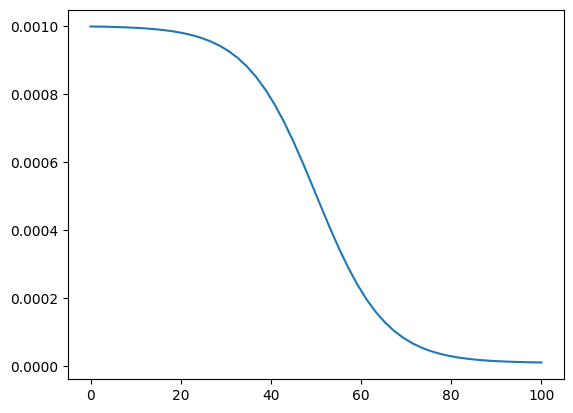

In [82]:
# Define learning rate scheduler 
# Use sigmoidal decay as the learning rate policy
def sigmoidal_decay(e, start=0, end=100, lr_start=1e-3, lr_end=1e-5):
    if e < start:
        return lr_start
    
    if e > end:
        return lr_end
    
    middle = (start + end) / 2
    s = lambda x: 1 / (1 + np.exp(-x))
    
    return s(13 * (-e + middle) / np.abs(end - start)) * np.abs(lr_start - lr_end) + lr_end

xs = np.linspace(0, 100)
ys = np.vectorize(sigmoidal_decay)(xs)
plt.plot(xs, ys)
plt.show()

EPOCHS = 3                       
lr = LearningRateScheduler(lambda e: sigmoidal_decay(e, end=EPOCHS))


In [110]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=4)
cvscores = []

In [134]:
# Run training for certain amount of epochs
from matplotlib import image
from matplotlib.pyplot import figure

for train, val in kf.split(x, y):
    x_train, x_val = x[train],x[val]
    y_train, y_val = y[train],y[val]

    model = ResNet()
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    History = model.fit(x_train,y_train, 
        validation_data = (x_val, y_val), 
        epochs = n_epochs,  verbose=1, class_weight = class_weight, callbacks = [lr,mc])

    plt.figure(figsize=(4, 4))
    plt.title("Learning curve")
    plt.plot(History.history["loss"], label="loss")
    plt.plot(History.history["val_loss"], label="val_loss")
    plt.plot( np.argmin(History.history["val_loss"]),
            np.min(History.history["val_loss"]),
            marker="x", color="r", label="best model")

    plt.xlabel("Epochs")
    plt.ylabel("Loss Value")
    plt.legend()
    plt.show()

    figure

    plt.figure(figsize=(4, 4))
    plt.title("Accuracy")
    plt.plot(History.history["accuracy"], label="accuracy")
    plt.plot(History.history["val_accuracy"], label="val_accuracy")
    plt.plot( np.argmax(History.history["val_accuracy"]),
            np.max(History.history["val_accuracy"]),
            marker="x", color="r", label="best model")

    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()
    
    # evaluate the model
    scores = model.evaluate(x_val, y_val, verbose=1)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
    
    print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

Epoch 1/80
 39/146 [=======>......................] - ETA: 2:39 - loss: 3.1890 - accuracy: 0.3862

KeyboardInterrupt: 

In [6]:
import tensorflow as tf
tf.config.list_physical_devices('GPU') 




[]